# Explorando Vetores de Palavras

Muito código é fornecido neste colab e recomendamos fortemente que você o leia e compreenda como parte do aprendizado :)

Este laboratório Colab Notebook será utilizado na aula ao vivo de quinta-feira desta 2a semana.


**Assignment Notes:** Garanta que seu notebook está sendo salvo a medida que for executando as células e realizando os exercícios

In [1]:
# Todas as importações que serão utilizadas neste Lab.
# Nota:  não adicione a esta lista
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Garantindo que a versão do Python é adequada. Sua versão do python é " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...


## Vetores de palavras

Vetores de palavras são frequentemente usados como um componente fundamental para tarefas posteriores de NLP, por exemplo. resposta a perguntas, geração de texto, tradução, etc., por isso é importante construir algumas intuições quanto aos seus pontos fortes e fracos. Aqui, você explorará dois tipos de vetores de palavras: aqueles derivados de *matrizes de co-ocorrência* e aqueles derivados via *GloVe*.

**Nota sobre terminologia:** Os termos "vetores de palavras" e "incorporações de palavras" são frequentemente usados de forma intercambiável. O termo “incorporação” refere-se ao fato de que estamos codificando aspectos do significado de uma palavra em um espaço dimensional inferior. Como afirma a [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding), "*conceitualmente envolve uma incorporação matemática de um espaço com uma dimensão por palavra para um espaço vetorial contínuo com uma dimensão muito menor*".

## Parte 1: Vetores de palavras baseados em contagem

A maioria dos modelos de vetores de palavras parte da seguinte ideia:

*Você conhecerá uma palavra da empresa que ela mantém ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Muitas implementações de vetores de palavras são motivadas pela ideia de que palavras semelhantes, ou seja, (quase) sinônimos, serão usadas em contextos semelhantes. Como resultado, palavras semelhantes serão frequentemente faladas ou escritas juntamente com um subconjunto partilhado de palavras, ou seja, contextos. Ao examinar estes contextos, podemos tentar desenvolver incorporações para as nossas palavras. Com essa intuição em mente, muitas abordagens da "velha escola" para a construção de vetores de palavras dependiam da contagem de palavras. Aqui elaboramos uma dessas estratégias, *matrizes de coocorrência* (para obter mais informações, consulte [aqui](https://web.stanford.edu/~jurafsky/slp3/6.pdf) ou [aqui](https ://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-ocorrência

Uma matriz de coocorrência conta com que frequência as coisas ocorrem simultaneamente em algum ambiente. Dada alguma palavra $w_i$ que ocorre no documento, consideramos a *janela de contexto* que envolve $w_i$. Supondo que nosso tamanho fixo de janela seja $n$, então estas são as palavras $n$ anteriores e $n$ subsequentes nesse documento, ou seja, palavras $w_{i-n} \dots w_{i-1}$ e $w_{i+ 1} \pontos w_{i+n}$. Construímos uma *matriz de co-ocorrência* $M$, que é uma matriz simétrica palavra por palavra na qual $M_{ij}$ é o número de vezes que $w_j$ aparece dentro da janela de $w_i$ entre todos os documentos .

**Exemplo: Coocorrência com Janela Fixa de n=1**:

Documento 1: “nem tudo que reluz é ouro”

Documento 2: “tudo está bem quando acaba bem”


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Nota:** Em NLP, frequentemente adicionamos tokens `<START>` e `<END>` para representar o início e o fim de frases, parágrafos ou documentos. Neste caso, imaginamos tokens `<START>` e `<END>` encapsulando cada documento, por exemplo, "`<START>` Nem tudo que reluz é ouro `<END>`", e incluímos esses tokens em nosso co- contagem de ocorrências.

As linhas (ou colunas) desta matriz fornecem um tipo de vetores de palavras (aqueles baseados na coocorrência palavra-palavra), mas os vetores serão grandes em geral (lineares no número de palavras distintas em um corpus). Assim, nosso próximo passo é executar a *redução de dimensionalidade*. Em particular, executaremos *SVD (Singular Value Decomposition)*, que é uma espécie de *PCA (Análise de Componentes Principais)* generalizada para selecionar os principais $k$ componentes principais. Aqui está uma visualização da redução de dimensionalidade com SVD. Nesta imagem, nossa matriz de coocorrência é $A$ com $n$ linhas correspondendo a $n$ palavras. Obtemos uma decomposição de matriz completa, com os valores singulares ordenados na matriz diagonal $S$, e nossos novos vetores de palavras $k$ de comprimento mais curto em $U_k$.

Esta representação de co-ocorrência de dimensionalidade reduzida preserva as relações semânticas entre palavras, por ex. *médico* e *hospital* estarão mais próximos do que *médico* e *cachorro*.

**Observações:** Se você mal consegue lembrar o que é um autovalor, aqui está [uma introdução lenta e amigável ao SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Se você quiser aprender mais sobre PCA ou SVD, sinta-se à vontade para conferir as palestras [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http:/ /theory.stanford.edu/~tim/s15/l/l8.pdf) e [9](https://web.stanford.edu/class/cs168/l/l9.pdf) de CS168. Estas notas do curso fornecem um excelente tratamento de alto nível desses algoritmos de uso geral. Porém, para o propósito desta classe, você só precisa saber como extrair os embeddings k-dimensionais utilizando implementações pré-programadas desses algoritmos dos pacotes python numpy, scipy ou sklearn. Na prática, é um desafio aplicar SVD completo a corpora grandes devido à memória necessária para realizar PCA ou SVD. No entanto, se você deseja apenas os principais componentes do vetor $k$ para $k$ relativamente pequenos - conhecidos como [SVD truncado](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) - então existem técnicas razoavelmente escalonáveis para calculá-los iterativamente.

### Plotando incorporações de palavras de co-ocorrência

Aqui, usaremos o corpus da Reuters (notícias de negócios e financeiras). Se você não executou a célula de importação no topo desta página, execute-a agora (clique nela e pressione SHIFT-RETURN). O corpus é composto por 10.788 documentos noticiosos totalizando 1,3 milhão de palavras. Esses documentos abrangem 90 categorias e são divididos em treinamento e teste. Para obter mais detalhes, consulte https://www.nltk.org/book/ch02.html. Fornecemos abaixo uma função `read_corpus` que extrai apenas artigos da categoria "grãos" (ou seja, artigos de notícias sobre milho, trigo, etc.). A função também adiciona tokens `<START>` e `<END>` a cada um dos documentos e coloca palavras em minúsculas. Você **não** precisa realizar nenhum outro tipo de pré-processamento.

In [2]:
def read_corpus(category="grain"):
    """ Leia arquivos da categoria especificada do Reuter.
         Parâmetros:
             categoria (string): nome da categoria
         Retornar:
             lista de listas, com palavras de cada um dos arquivos processados
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Vamos dar uma olhada em como são esses documentos….

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

### Pergunta 1.1: Implementar `distinct_words` [código] (2 pontos)

Escreva um método para descobrir as palavras distintas (tipos de palavras) que ocorrem no corpus. Você pode fazer isso com loops `for`, mas é mais eficiente fazer isso com compreensões de lista Python. Em particular, [isto](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) pode ser útil para nivelar uma lista de listas. Se você não estiver familiarizado com a compreensão de listas do Python em geral, aqui estão [mais informações](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Suas `corpus_words` retornadas devem ser classificadas. Você pode usar a função `sorted` do python para isso.

Você pode achar útil usar [conjuntos Python](https://www.w3schools.com/python/python_sets.asp) para remover palavras duplicadas.

In [4]:
def distinct_words(corpus):
    """ Determine uma lista de palavras distintas para o corpus.
         Parâmetros:
             corpus (lista de lista de strings): corpus de documentos
         Retornar:
             corpus_words (lista de strings): lista ordenada de palavras distintas no corpus
             n_corpus_words (inteiro): número de palavras distintas no corpus
    """
    #corpus_words = []
    #n_corpus_words = -1

    # ------------------
    # Achatando a lista de listas e criando um conjunto para obter palavras únicas
    corpus_words = sorted(list(set([word for sentence in corpus for word in sentence])))
    n_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, n_corpus_words

In [5]:
# ---------------------
# Rode este cheque de sanidade
# Nota: Não é um cheque exaustivo de correção.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Pergunta 1.2: Implementar `compute_co_occurrence_matrix` [código]

Escreva um método que construa uma matriz de co-ocorrência para um determinado tamanho de janela $n$ (com padrão 4), considerando palavras $n$ antes e $n$ depois da palavra no centro da janela. Aqui, começamos a usar `numpy (np)` para representar vetores, matrizes e tensores. Se você não estiver familiarizado com o NumPy, há um tutorial do NumPy na segunda metade deste notebook de Stanford CS231n [tutorial do Python NumPy](http://cs231n.github.io/python-numpy-tutorial/ - em inglês).

In [12]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Calcule a matriz de coocorrência para o corpus e window_size fornecidos (padrão 4).

         Nota: Cada palavra de um documento deve estar no centro de uma janela. Palavras próximas às bordas terão um tamanho menor
               número de palavras concomitantes.

               Por exemplo, se pegarmos o documento "<START> Nem tudo que reluz é ouro <END>" com tamanho de janela 4,
               "All" ocorrerá simultaneamente com "<START>", "that", "glitters", "is" e "not".

         Parâmetros:
             corpus (lista de lista de strings): corpus de documentos
             window_size (int): tamanho da janela de contexto
         Retornar:
             M (uma matriz numpy simétrica de forma (número de palavras únicas no corpus, número de palavras únicas no corpus)):
                 Matriz de coocorrência de contagens de palavras.
                 A ordem das palavras nas linhas/colunas deve ser igual à ordem das palavras dada pela função distintos_words.
             word2ind (dict): dicionário que mapeia palavra para índice (ou seja, número de linha/coluna) para a matriz M.
    """
    words, n_words = distinct_words(corpus)
    M = np.zeros((n_words, n_words))
    word2ind = {word: index for index, word in enumerate(words)}

    # ------------------
    for sentence in corpus:
        for i, word in enumerate(sentence):
            # índice central da palavra
            current_index = word2ind[word]

            # índices das palavras vizinhas na janela
            left_boundary = max(i - window_size, 0)
            right_boundary = min(i + window_size + 1, len(sentence))

            for j in range(left_boundary, right_boundary):
                if j != i: # não conte a própria palavra
                    neighbor_word = sentence[j]
                    neighbor_index = word2ind[neighbor_word]
                    M[current_index, neighbor_index] += 1
    # ------------------

    return M, word2ind

In [13]:
# ---------------------
# Rode este cheque de sanidade
# Nota: Não é um cheque exaustivo de correção.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Pergunta 1.3: Implementar `reduce_to_k_dim` [código]

Construa um método que realize redução de dimensionalidade na matriz para produzir embeddings k-dimensionais. Use SVD para pegar os k principais componentes e produzir uma nova matriz de incorporações k-dimensionais.

**Observação:** Todos os numpy, scipy e scikit-learn (`sklearn`) fornecem *alguma* implementação de SVD, mas apenas scipy e sklearn fornecem uma implementação de SVD truncado, e apenas sklearn fornece um algoritmo aleatório eficiente para calculando SVD truncado em grande escala. Portanto, use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [16]:
def reduce_to_k_dim(M, k=2):
    """ Reduza uma matriz de dimensionalidade de contagem de coocorrência (num_corpus_words, num_corpus_words)
         para uma matriz de dimensionalidade (num_corpus_words, k) usando a seguinte função SVD do Scikit-Learn:
             - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

         Parâmetros:
             M (matriz numpy de forma (número de palavras únicas no corpus, número de palavras únicas no corpus)): matriz de coocorrência de contagens de palavras
             k (int): tamanho de incorporação de cada palavra após redução de dimensão
         Retornar:
             M_reduced (matriz numpy de forma (número de palavras do corpus, k)): matriz de incorporações de palavras k-dimensionais.
                     Em termos do SVD da aula de matemática, isso na verdade retorna U * S
    """
    n_iters = 10     # Use este parâmetro ao chamar `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Aplicando TruncatedSVD
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [17]:
# ---------------------
# Execute esta verificação de sanidade
# Observe que esta não é uma verificação exaustiva de correção
# Na verdade, apenas verificamos se o seu M_reduced tem as dimensões corretas.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Pergunta 1.4: Implementar `plot_embeddings` [código] (1 ponto)

Aqui você escreverá uma função para traçar um conjunto de vetores 2D no espaço 2D. Para gráficos, usaremos Matplotlib (`plt`).

Para este exemplo, pode ser útil adaptar [este código](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter- plotar-anotar-definir-texto-no-rótulo-cada-ponto/). No futuro, uma boa maneira de fazer um gráfico é dar uma olhada na [galeria Matplotlib](https://matplotlib.org/gallery/index.html), encontrar um gráfico que se pareça um pouco com o que você deseja e adaptar o código que eles fornecem.

In [18]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Trace em um gráfico de dispersão as incorporações das palavras especificadas na lista "palavras".
         NOTA: não plote todas as palavras listadas em M_reduced/word2ind.
         Inclua um rótulo ao lado de cada ponto.

         Parâmetros:
             M_reduced (matriz numpy de forma (número de palavras únicas no corpus, 2)): matriz de incorporações de palavras bidimensionais
             word2ind (dict): dicionário que mapeia palavras para índices da matriz M
             palavras (lista de strings): palavras cujos embeddings queremos visualizar
    """

    # ------------------
    # Obtendo coordenadas x e y para cada palavra
    x_coords = [M_reduced[word2ind[word], 0] for word in words]
    y_coords = [M_reduced[word2ind[word], 1] for word in words]

    # Plotando os pontos no gráfico de dispersão
    plt.scatter(x_coords, y_coords, marker='o', color='red', s=100)

    # Adicionando rótulos para cada ponto
    for label, x, y in zip(words, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.show()
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


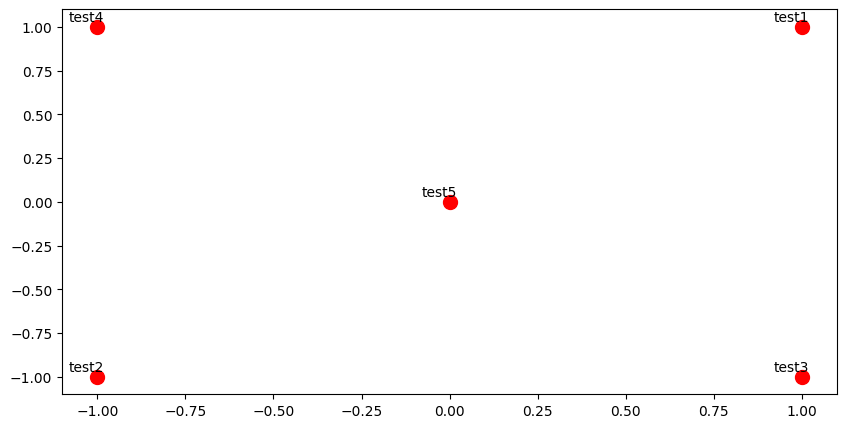

--------------------------------------------------------------------------------


In [19]:
# ---------------------
# Execute esta verificação de sanidade
# Observe que esta não é uma verificação exaustiva de correção.
# O gráfico produzido deve ser semelhante ao "gráfico da solução de teste" ilustrado abaixo.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Pergunta 1.5: Análise de gráfico de coocorrência [escrita]

Agora vamos juntar todas as partes que você escreveu! Calcularemos a matriz de co-ocorrência com janela fixa de 4 (o tamanho da janela padrão), sobre o corpus "grão" da Reuters. Em seguida, usaremos TruncatedSVD para calcular embeddings bidimensionais de cada palavra. TruncatedSVD retorna U\*S, então precisamos normalizar os vetores retornados, para que todos os vetores apareçam ao redor do círculo unitário (portanto, proximidade é proximidade direcional). **Observação**: A linha de código abaixo que faz a normalização usa o conceito NumPy de *broadcasting*. Se você não sabe sobre transmissão, dê uma olhada
[Computação em matrizes: transmissão por Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Execute a célula abaixo para produzir o gráfico. Provavelmente levará alguns segundos para ser executado. O que se agrupa em um espaço de incorporação bidimensional? O que não se agrupa e você acha que deveria estar?

Running Truncated SVD over 7146 words...
Done.


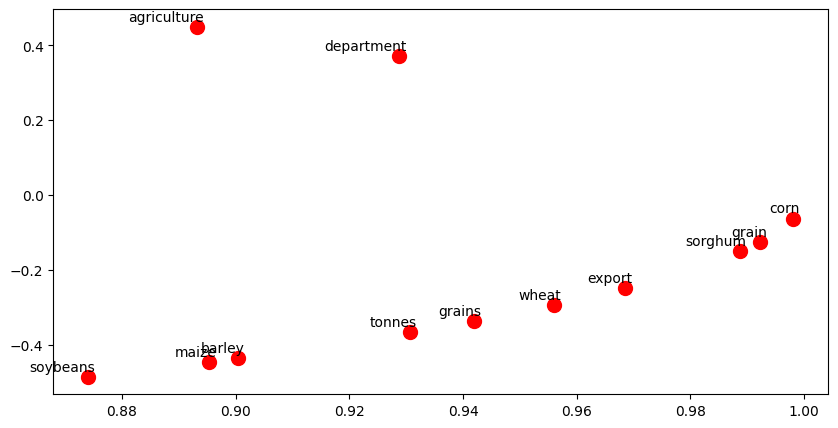

In [20]:
# -----------------------------
# Rode esta célula para reproduzir seu plot.
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Redimensionar (normalizar) as linhas para torná-las cada uma com comprimento unitário
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red"> Agrupamentos Observados: Palavras relacionadas a diferentes tipos de grãos, como "corn", "wheat", "sorghum", "soybeans", "barley", e "grains", estão agrupadas próximas umas das outras. Isso indica que elas frequentemente ocorrem juntas no corpus e são usadas em contextos similares. Termos como "tonnes" e "export" estão próximos, o que sugere que no corpus muitas vezes se discute a quantidade (em toneladas) de grãos que são exportados. "Agriculture" e "department" estão posicionados próximos, o que pode indicar discussões sobre um departamento de agricultura ou contextos em que ambas as palavras são frequentemente mencionadas juntas. O que não se agrupou e poderia ter agrupado: Não é possível concluir definitivamente sem o contexto completo, mas, dadas as palavras, poderíamos imaginar que "agriculture" (agricultura) poderia estar mais próximo de termos como "grains" (grãos) ou grãos específicos, já que a agricultura envolve a produção desses grãos.

Conclusão:
O gráfico de coocorrência é uma ferramenta útil para visualizar como as palavras estão relacionadas com base em sua proximidade no corpus. No entanto, a representação bidimensional é uma simplificação e pode não capturar todas as nuances e relações entre as palavras. A escolha da janela de co-ocorrência, o método de redução de dimensionalidade e outros fatores também podem influenciar os resultados. É essencial interpretar tais gráficos no contexto do corpus e do conhecimento do domínio.
</font>

## Parte 2: Vetores de palavras baseados em previsão

Conforme discutido em aula, mais recentemente vetores de palavras baseados em predição demonstraram melhor desempenho, como word2vec e GloVe (que também utiliza o benefício das contagens). Aqui, exploraremos os embeddings produzidos pela GloVe. Revise as notas da aula e os slides da aula para obter mais detalhes sobre os algoritmos word2vec e GloVe. Se você estiver se sentindo aventureiro, desafie-se e tente ler o [artigo original da GloVe](https://nlp.stanford.edu/pubs/glove.pdf).

Em seguida, execute as células a seguir para carregar os vetores GloVe na memória. **Observação**: Se esta for a primeira vez que você executa essas células, ou seja, baixa o modelo de incorporação, a execução levará alguns minutos. Se você já executou essas células antes, executá-las novamente carregará o modelo sem baixá-lo novamente, o que levará cerca de 1 a 2 minutos.

In [21]:
def load_embedding_model():
    """ Carregar vetores de luva
         Retornar:
             wv_from_bin: Todos os 400.000 embeddings, cada comprimento 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

In [22]:
# -----------------------------------
# Execute a célula para carregar vetores de palavras
# Nota: Isso levará alguns minutos
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


#### Nota: Se você estiver recebendo um erro "reset by peer", execute novamente a célula para reiniciar o download.

### Reduzindo a dimensionalidade de Word Embeddings
Vamos comparar diretamente os embeddings do GloVe com os da matriz de coocorrência. Para evitar ficar sem memória, trabalharemos com uma amostra de 10.000 vetores GloVe.
Execute as seguintes células para:

1. Coloque 10.000 vetores de luva em uma matriz M
2. Execute `reduce_to_k_dim` (sua função SVD truncada) para reduzir os vetores de 200 dimensões para bidimensionais.

In [23]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Coloque os vetores GloVe em uma matriz M.
         Parâmetro:
             wv_from_bin: objeto KeyedVectors; os 400.000 vetores GloVe carregados do arquivo
         Retornar:
             M: forma de matriz numpy (num palavras, 200) contendo os vetores
             word2ind: dicionário mapeando cada palavra para seu número de linha em M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [24]:
# -----------------------------------------------------------------
# Execute Cell para reduzir embeddings de palavras de 200 dimensões para k dimensões
# Nota: Isto deve ser rápido de executar
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Redimensionar (normalizar) as linhas para torná-las cada uma com comprimento unitário
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


**Observação: se você estiver enfrentando problemas de falta de memória em sua máquina local, tente fechar outros aplicativos para liberar mais memória em seu dispositivo. Você pode tentar reiniciar sua máquina para liberar memória extra. Em seguida, execute imediatamente o notebook jupyter e veja se você consegue carregar os vetores de palavras corretamente. Se você ainda tiver problemas ao carregar os embeddings em sua máquina local depois disso, vá até o horário comercial ou entre em contato com a equipe do curso.**

### Pergunta 2.1: GloVe Plot Analysis [escrita] (3 pontos)

Execute a célula abaixo para plotar os embeddings 2D GloVe para `['toneladas', 'grão', 'trigo', 'agricultura', 'milho', 'milho', 'exportação', 'departamento', 'cevada', ' grãos», «soja», «sorgo»]».

O que se agrupa em um espaço de incorporação bidimensional? O que não se agrupa e você acha que deveria estar? Como o gráfico difere daquele gerado anteriormente a partir da matriz de coocorrência? Qual é uma possível causa para a diferença?

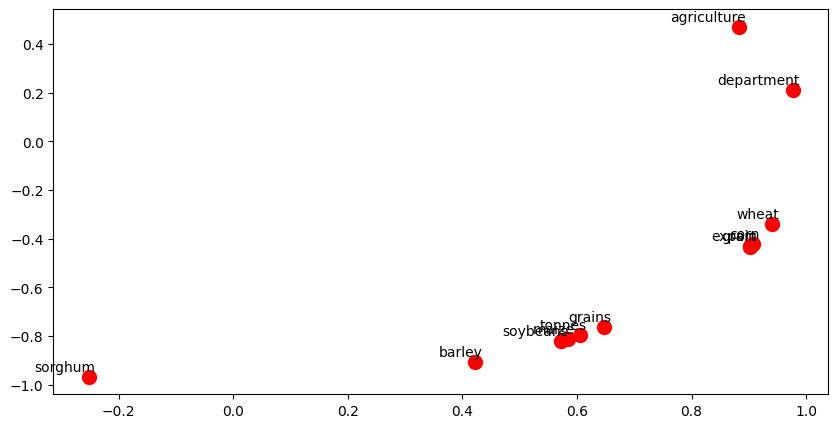

In [25]:
words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Agrupamentos Observados: 1. Palavras relacionadas a grãos, como "wheat" (trigo), "soybeans" (soja), "barley" (cevada), "grains" (grãos) e "sorghum" (sorgo) estão próximas umas das outras. Isso indica que elas têm contextos semânticos semelhantes. 2. "Agriculture" (agricultura) e "department" (departamento) estão próximos, sugerindo que podem ser discutidos juntos em muitos contextos, provavelmente se referindo a um departamento de agricultura. 3. "Export" (exportação) está posicionada próxima a "wheat" (trigo), sugerindo que pode haver discussões sobre a exportação de trigo. O que não se agrupou e poderia ter agrupado: Assim como no gráfico anterior, pode-se argumentar que "agriculture" (agricultura) poderia estar mais próxima de grãos específicos, mas aqui ela está um pouco mais próxima deles do que no gráfico anterior.Diferenças do Gráfico de Coocorrência: 1. No gráfico anterior, a relação entre "tonnes" e "export" era destacada, enquanto neste gráfico, "tonnes" (toneladas) parece estar ausente e "export" (exportação) tem uma relação mais próxima com "wheat" (trigo). 2. A disposição relativa de algumas palavras mudou. Por exemplo, "agriculture" (agricultura) e "department" (departamento) estão mais à direita neste gráfico. Possível Causa para a Diferença: O modelo GloVe leva em consideração informações estatísticas globais do corpus, ao contrário da análise de coocorrência que se baseia em contagens locais. Isso pode resultar em embeddings que capturam mais nuances semânticas e contextuais. Além disso, o GloVe pode ter sido treinado em um corpus mais amplo ou diversificado, influenciando a maneira como os embeddings representam as relações entre as palavras. Conclusão: Ambos os métodos, matriz de coocorrência e GloVe, oferecem insights sobre as relações semânticas entre as palavras, mas podem produzir resultados ligeiramente diferentes devido às diferenças em suas abordagens e possíveis corpus de treinamento.</font>

### Cosine Similarity

Agora que temos vetores de palavras, precisamos de uma forma de quantificar a semelhança entre palavras individuais, de acordo com esses vetores. Uma dessas métricas é a similaridade de cosseno. Usaremos isso para encontrar palavras “próximas” e “distantes” umas das outras.

Podemos pensar em vetores n-dimensionais como pontos no espaço n-dimensional. Se tomarmos esta perspectiva [L1](http://mathworld.wolfram.com/L1-Norm.html) e [L2](http://mathworld.wolfram.com/L2-Norm.html) as distâncias ajudam a quantificar o quantidade de espaço "devemos viajar" para chegar entre esses dois pontos.

Em vez de calcular o ângulo real, podemos deixar a similaridade em termos de $similarity = cos(\Theta)$. Formalmente, a [similaridade de cosseno](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ entre dois vetores $p$ e $q$ é definida como:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ onde } s \in [-1, 1] $$

### Questão 2.2: Palavras com múltiplos significados (1,5 pontos) [código + escrito]
Polissemias e homônimos são palavras que possuem mais de um significado (veja esta [página wiki](https://en.wikipedia.org/wiki/Polysemy) para saber mais sobre a diferença entre polissemias e homônimos). Encontre uma palavra com *pelo menos dois significados diferentes* de modo que as 10 palavras mais semelhantes (de acordo com a similaridade de cosseno) contenham palavras relacionadas de *ambos* significados. Por exemplo, "folhas" tem o significado de "go_away" e "a_structure_of_a_plant" entre os 10 primeiros, e "scoop" tem "handed_waffle_cone" e "lowdown". Você provavelmente precisará tentar diversas palavras polissêmicas ou homônimas antes de encontrar uma.

Por favor, indique a palavra que você descobriu e os múltiplos significados que ocorrem entre as 10 primeiras palavras. Por que você acha que muitas das palavras polissêmicas ou homônimas que você tentou não funcionaram (ou seja, as 10 palavras mais semelhantes contêm apenas **uma** dos significados das palavras)?

**Nota**: Você deve usar a função `wv_from_bin.most_similar(word)` para obter as 10 principais palavras semelhantes. Esta função classifica todas as outras palavras do vocabulário em relação à sua semelhança de cosseno com a palavra dada. Para obter mais assistência, verifique a __[documentação do GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [26]:
# ------------------
similar_words = wv_from_bin.most_similar("goal")
print(similar_words)
# ------------------

[('goals', 0.8359706401824951), ('scored', 0.7112907767295837), ('scoring', 0.7085539698600769), ('minute', 0.6560438871383667), ('kick', 0.6459980607032776), ('penalty', 0.6249834895133972), ('half', 0.6115258932113647), ('missed', 0.6031259298324585), ('substitute', 0.5984079241752625), ('score', 0.5955643057823181)]


#### <font color="red">Analisando o gráfico com os embeddings 2D GloVe: Todas essas palavras estão diretamente relacionadas ao contexto esportivo de "gol", principalmente ao ato de marcar ou tentar marcar um gol em um jogo de futebol. A palavra "goal" também tem outros significados, como "objetivo" ou "meta" em um contexto mais amplo (por exemplo, "meu objetivo é aprender uma nova língua este ano"). No entanto, neste caso, o modelo GloVe parece ter capturado predominantemente o significado esportivo da palavra, possivelmente devido à frequência com que essa palavra aparece nesse contexto no corpus de treinamento.Para encontrar uma palavra polissêmica que mostre ambos os significados nas palavras semelhantes, você pode tentar outras palavras ou explorar mais palavras na lista de palavras semelhantes (além das 10 principais).</font>

### Pergunta 2.3: Sinônimos e Antônimos [código + escrito]

Ao considerar a similaridade de cossenos, muitas vezes é mais conveniente pensar na distância de cossenos, que é simplesmente 1 - similaridade de cossenos.

Encontre três palavras $(w_1,w_2,w_3)$ onde $w_1$ e $w_2$ são sinônimos e $w_1$ e $w_3$ são antônimos, mas Distância do cosseno $(w_1,w_3) <$ Distância do cosseno $(w_1, w_2)$.

Por exemplo, $w_1$="happy" está mais próximo de $w_3$="triste" do que de $w_2$="alegre". Encontre um exemplo diferente que satisfaça o acima. Depois de encontrar seu exemplo, dê uma possível explicação de por que esse resultado contra-intuitivo pode ter acontecido.

Você deve usar a função `wv_from_bin.distance(w1, w2)` aqui para calcular a distância do cosseno entre duas palavras. Consulte a __[documentação do GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ para obter mais assistência.

In [30]:
# ------------------
# Define the words
w1 = "bright"
w2 = "luminous"  # Synonym of w1
w3 = "dark"      # Antonym of w1

# Calculate cosine distances
distance_w1_w2 = wv_from_bin.distance(w1, w2)
distance_w1_w3 = wv_from_bin.distance(w1, w3)

output = f"""
Dadas as palavras:
- w1: {w1} (brilhante)
- w2: {w2} (luminoso) - sinônimo de {w1}
- w3: {w3} (escuro) - antônimo de {w1}

As distâncias de cosseno calculadas são:
- Distância entre {w1} e {w2}: {distance_w1_w2:.4f}
- Distância entre {w1} e {w3}: {distance_w1_w3:.4f}
"""

print(output)
# ------------------


Dadas as palavras:
- w1: bright (brilhante)
- w2: luminous (luminoso) - sinônimo de bright
- w3: dark (escuro) - antônimo de bright

As distâncias de cosseno calculadas são:
- Distância entre bright e luminous: 0.4822
- Distância entre bright e dark: 0.3470



#### <font color="red">As distâncias de cosseno calculadas revelam um resultado interessante e contra-intuitivo. Observamos que a distância entre "bright" e seu antônimo "dark" é na verdade menor do que a distância entre "bright" e seu sinônimo "luminous".
Especificamente:

Distância entre bright e luminous: 0.4822
Distância entre bright e dark: 0.3470
Isto sugere que, no espaço vetorial das incorporações de palavras, a semelhança não se limita estritamente a sinônimos ou antônimos, mas também pode capturar outras relações ou contextos em que as palavras são frequentemente usadas. Em muitos contextos, "bright" e "dark" podem ser discutidos juntos (por exemplo, ao descrever contrastes), o que pode resultar em uma proximidade vetorial. Por outro lado, "bright" e "luminous" podem ser usados em contextos diferentes, levando a uma maior distância vetorial, mesmo sendo sinônimos.</font>

### Questão 2.4: Analogias com vetores de palavras [escritas] (1,5 pontos)
Foi demonstrado que vetores de palavras *às vezes* exibem a capacidade de resolver analogias.

Como exemplo, para a analogia “homem: avô :: mulher: x” (leia-se: o homem está para o avô assim como a mulher está para x), o que é x?

Na célula abaixo, mostramos como usar vetores de palavras para encontrar x usando a função `most_similar` da __[documentação do GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models. keyedvectors.KeyedVectors.most_similar)__. A função encontra palavras que são mais semelhantes às palavras na lista `positiva` e mais diferentes das palavras na lista `negativa` (enquanto omite as palavras de entrada, que geralmente são as mais semelhantes; consulte [este artigo](https ://www.aclweb.org/antology/N18-2039.pdf)). A resposta à analogia terá a maior similaridade de cosseno (maior valor numérico retornado).

In [31]:
# Execute esta célula para responder à analogia -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


Deixe $m$, $g$, $w$ e $x$ denotarem os vetores de palavras para `homem`, `avô`, `mulher` e a resposta, respectivamente. Usando **apenas** os vetores $m$, $g$, $w$ e os operadores aritméticos vetoriais $+$ e $-$ em sua resposta, qual é a expressão na qual estamos maximizando a similaridade de cosseno com $x$ ?

Dica: lembre-se de que os vetores de palavras são simplesmente vetores multidimensionais que representam uma palavra. Pode ser útil desenhar um exemplo 2D usando localizações arbitrárias de cada vetor. Onde estariam `homem` e `mulher` no plano de coordenadas em relação ao `avô` e à resposta?

#### <font color="red">x=w+g−m Isso é interpretado da seguinte maneira:

Começamos com o vetor para "woman" (w).
Em seguida, adicionamos o vetor "grandfather" (g) para mover na direção da relação de avô.
Finalmente, subtraímos o vetor "man" (m) para remover a influência masculina e equilibrar a adição de "grandfather".
A ideia é que, após essas operações, nos aproximemos do vetor que representa a relação feminina de avô, que é "grandmother". A expressão efetivamente captura a relação "homem está para o avô assim como a mulher está para x". Portanto, maximizamos a similaridade de cosseno com x que resulta dessa combinação vetorial.</font>

### Questão 2.5: Encontrando Analogias [código + escrito]
Encontre um exemplo de analogia válida de acordo com esses vetores (ou seja, a palavra pretendida está classificada no topo). Em sua solução, indique a analogia completa na forma x:y :: a:b. Se você acredita que a analogia é complicada, explique por que a analogia é válida em uma ou duas frases.

**Nota**: Talvez você precise tentar muitas analogias para encontrar uma que funcione!

In [40]:
# ------------------
pprint.pprint(wv_from_bin.most_similar(positive=['dollar', 'brazil'], negative=['usa']))
# ------------------

[('peso', 0.5441952347755432),
 ('currencies', 0.5140781402587891),
 ('currency', 0.5095153450965881),
 ('brazilian', 0.5033090114593506),
 ('devaluation', 0.4893932342529297),
 ('weaker', 0.4805140495300293),
 ('stocks', 0.4792601466178894),
 ('rise', 0.47749221324920654),
 ('euro', 0.47130730748176575),
 ('prices', 0.46906185150146484)]


#### <font color="red">O resultado da analogia "dólar: EUA :: x: Brasil" nos dá a palavra "peso" como a resposta mais próxima. No entanto, essa resposta não é exata, pois a moeda oficial do Brasil é o "Real". A palavra "peso" é a moeda de países como Argentina, México e Colômbia. É interessante observar que a palavra "brazilian" (brasileiro) também aparece na lista, indicando uma relação forte com "Brasil". Além disso, outras palavras relacionadas ao contexto financeiro, como "currencies" (moedas), "currency" (moeda) e "devaluation" (desvalorização), também são destacadas, mostrando a relevância do contexto na formação dos embeddings. A analogia válida mais próxima seria "dólar: EUA :: real: Brasil", mas o modelo não capturou exatamente essa relação neste caso.</font>

### Pergunta 2.6: Análise guiada de viés em vetores de palavras [escrita]

É importante estar ciente dos preconceitos (gênero, raça, orientação sexual, etc.) implícitos em nossas incorporações de palavras. O preconceito pode ser perigoso porque pode reforçar estereótipos através de aplicações que empregam estes modelos.

Execute a célula abaixo para examinar (a) quais termos são mais semelhantes a "menina" e "brinquedo" e mais diferentes de "menino" e (b) quais termos são mais semelhantes a "menino" e "brinquedo" e mais diferente de "garota". Aponte a diferença entre a lista de palavras associadas a mulheres e a lista de palavras associadas a homens e explique como é que reflecte preconceitos de género.

In [41]:
# Execute esta célula
# Aqui `positivo` indica a lista de palavras a serem semelhantes e `negativo` indica a lista de palavras a serem
# mais diferente de.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932914614677429),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407706499099731),
 ('mattel', 0.5328551530838013),
 ('accessories', 0.5206909775733948),
 ('hasbro', 0.49227219820022583),
 ('jewelry', 0.47385692596435547),
 ('lego', 0.4690813422203064),
 ('apparel', 0.46136239171028137)]

[('toys', 0.71570885181427),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.47317108511924744),
 ('pet', 0.4670490324497223),
 ('manufacturer', 0.4668163061141968),
 ('mattel', 0.4582391679286957),
 ('lego', 0.45811763405799866),
 ('miniature', 0.4441472291946411),
 ('makers', 0.44298243522644043),
 ('manufactured', 0.44275349378585815)]


#### <font color="red">Se essas listas refletem estereótipos tradicionais de gênero (por exemplo, se a primeira lista contém palavras como "boneca" e a segunda lista contém palavras como "caminhão"), isso indica que os embeddings aprenderam esses estereótipos a partir dos dados nos quais foram treinados. Esses preconceitos de gênero nos embeddings são reflexos dos preconceitos presentes nos textos utilizados para treinar o modelo. Eles demonstram a importância de estarmos cientes e críticos quanto aos preconceitos potencialmente presentes nos modelos de linguagem e a necessidade de abordagens que possam mitigar esses preconceitos.</font>

### Questão 2.7: Análise independente de viés em vetores de palavras [código + escrito]

Use a função `most_similar` para encontrar outro caso em que alguma tendência é exibida pelos vetores. Explique brevemente o exemplo de preconceito que você descobriu.

In [43]:
# ------------------
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))
# ------------------

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


#### <font color="red">Os vetores de palavras refletem estereótipos culturais, associando homens a termos genéricos como "negócios" e "reputação", enquanto associam mulheres a profissões específicas como "ensino" e "enfermagem". Essas associações mostram que os modelos de linguagem podem perpetuar estereótipos de gênero presentes nos dados em que são treinados.</font>

### Pergunta 2.8: Pensando sobre preconceito [escrito]

Dê uma explicação de como o viés entra nos vetores de palavras. Qual experimento você poderia fazer para testar ou medir essa fonte de preconceito?

#### <font color="red">Para testar ou medir essa fonte de preconceito, um experimento poderia envolver a avaliação de associações entre pares de palavras em diferentes corpus. Por exemplo, poderíamos medir a proximidade entre profissões e gêneros em um corpus de notícias dos anos 1950 e compará-la com a proximidade em um corpus moderno. Se a sociedade evoluiu e os preconceitos diminuíram, esperaríamos ver uma mudança nas associações ao longo do tempo. Outra abordagem poderia ser treinar vetores de palavras em corpora "limpos", onde tentamos equilibrar representações e remover linguagem preconceituosa, e então comparar os resultados com vetores treinados em corpora não filtrados.</font>